# Plot attention


In [52]:
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torchvision import transforms

from local_python.general_utils import (
    print_parameters,
    load_model,
)

from local_python.dataset_util import (
    create_dataloader,
)

In [53]:
patch_size = 16
number_of_heads = 3
normalise_mean = (0.485, 0.456, 0.406)  # ImageNet
normalise_std = (0.229, 0.224, 0.225)  # ImageNet
number_of_colums = 2

checkpoint_paths = (
    "../model_weights/vit_t16_v2/ViT_T16-Random_headless.pth",
    # "../model_weights/vit_t16_v2/ViT_T16-ImageNet_1k_SSL_Dino_headless.pth",
    # "../model_weights/vit_t16_v2/ViT_T16-ImageNet_AugReg_headless.pth",
    # "../model_weights/vit_t16_v2/ViT_T16-Derma_SSL_Dino_headless.pth",
    # "../model_weights/vit_t16_v2/ViT_T16-Plant_SSL_Dino_headless.pth",
)
dataset_path = "../datasets/plot_images.csv"

In [54]:
assert torch.cuda.is_available()
n_devices = torch.cuda.device_count()
for i in range(0, n_devices):
    print(torch.cuda.get_device_name(i))

device = torch.device("cuda")

NVIDIA GeForce GTX 960


In [55]:
dl_full = create_dataloader(dataset_path)

In [56]:
columns = []

for checkpoint_path in checkpoint_paths:
    rows = []

    model = load_model(checkpoint_path, use_ssl_library=True)
    assert hasattr(
        model.model, "get_last_selfattention"
    ), "get_last_selfattention() is only implemented in the ssl_library for ViT"
    model = model.to(device)
    model.eval()

    for images, target_codes, _ in dl_full:
        attention_shape = (
            number_of_heads,
            images.shape[-2] // patch_size,
            images.shape[-1] // patch_size,
        )
        images = images.to(device)
        attentions = model.model.get_last_selfattention(images)
        for i in range(len(images)):
            if "skip" == target_codes[i]:
                continue
            img = transforms.ToPILImage()(
                images[i].cpu() * torch.tensor(normalise_std)[:, None, None]
                + torch.tensor(normalise_mean)[:, None, None]
            )
            attention = attentions[i].cpu()[:, 0, 1:].reshape(attention_shape)
            img_att = sum(
                attention[i] * 1 / attention.shape[0] for i in range(attention.shape[0])
            )

            rows.append((img, img_att, target_codes[i]))
    columns.append(rows)

Loading vit_tiny_patch16_224 from timm-library


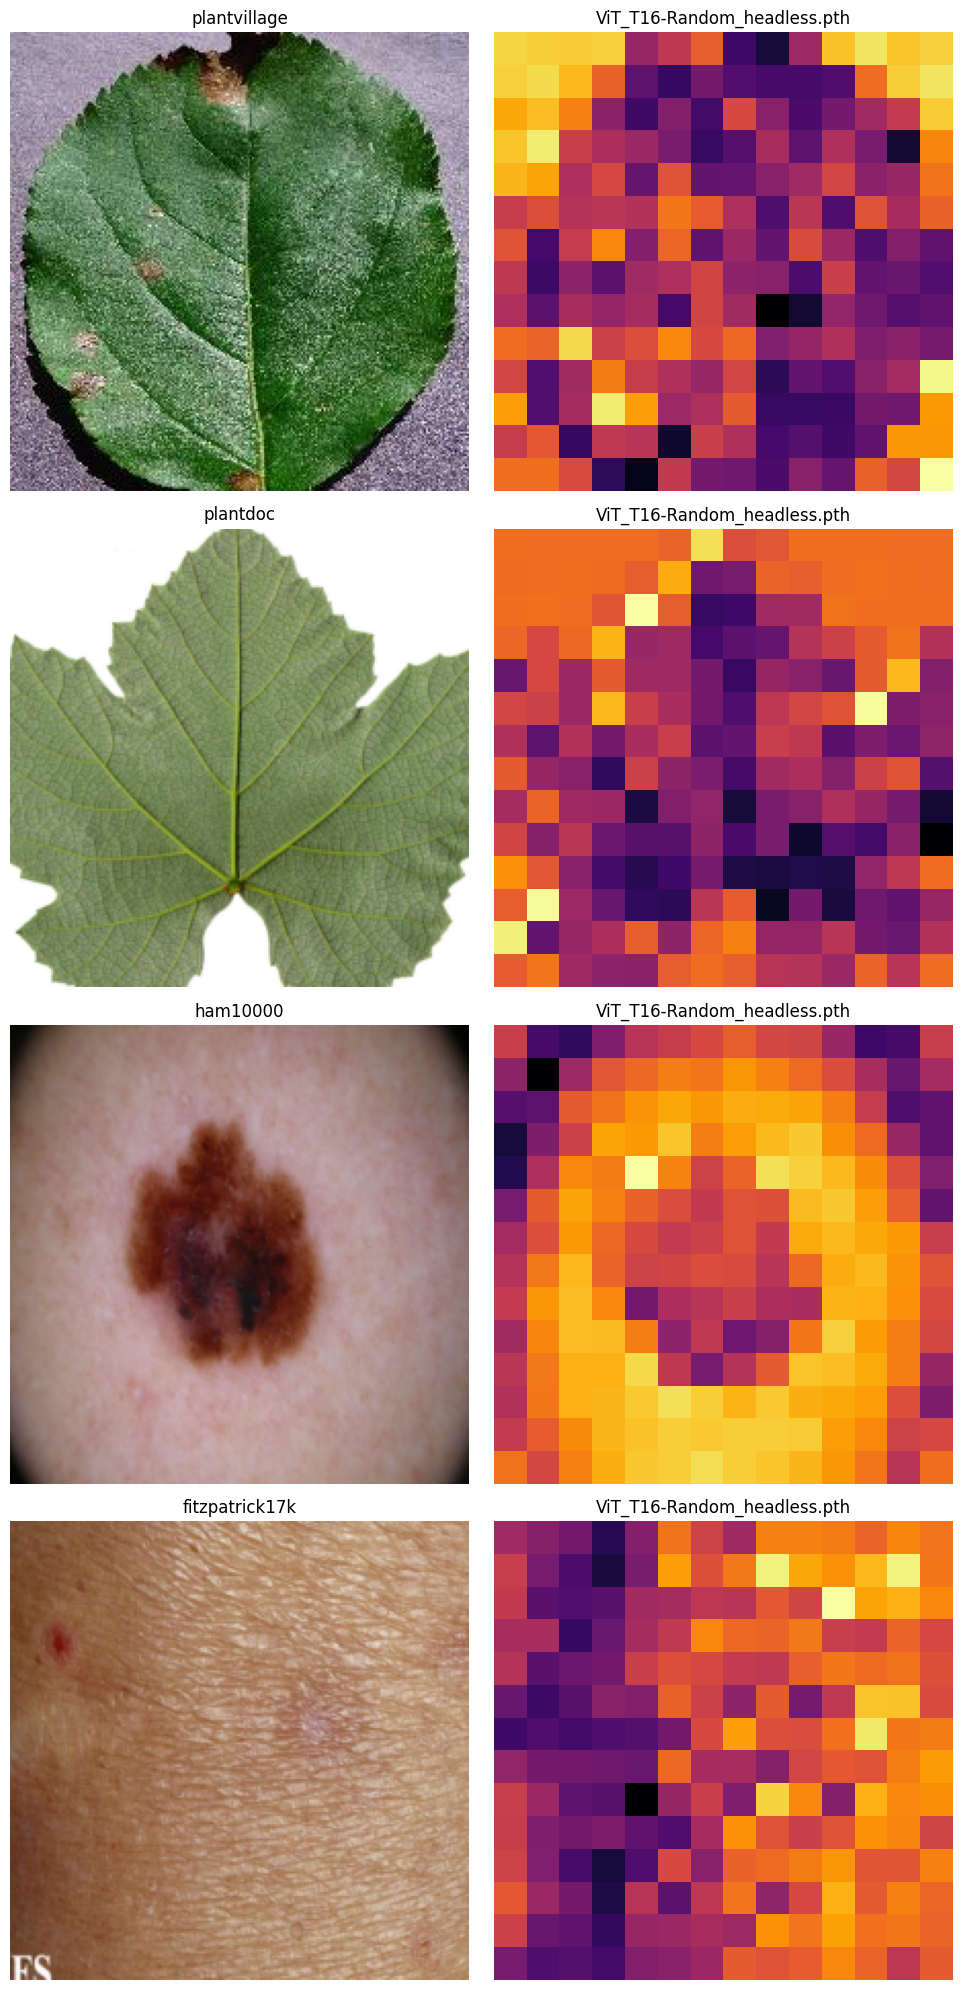

In [57]:
number_of_columns = len(columns) + 1
number_of_rows = len(columns[0])

fig, ax = plt.subplots(
    number_of_rows,
    number_of_columns,
    figsize=(5 * number_of_columns, 5 * number_of_rows),
    squeeze=False,
)

for i_col, column in enumerate(columns):
    for i_row, row in enumerate(column):
        if i_col == 0:
            ax[i_row][0].imshow(row[0])
            ax[i_row][0].set_title(row[2])
        ax[i_row][i_col + 1].imshow(row[1], cmap="inferno")
        ax[i_row][i_col + 1].set_title(os.path.basename(checkpoint_paths[i_col]))

# imshow(att_img, cmap="inferno", alpha=0.3)

[ax.set_axis_off() for ax in ax.ravel()]
fig.tight_layout()
plt.show()

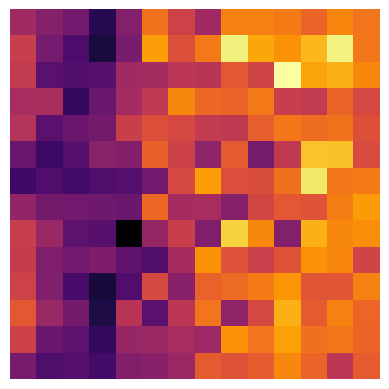

In [58]:
# number_of_columns = len(columns) + 1
# number_of_rows = len(columns[0])

# fig, ax = plt.subplots(
#     number_of_rows,
#     number_of_columns,
#     figsize=(5 * number_of_columns, 5 * number_of_rows),
#     squeeze=False,
# )
target_dir = "../presentations/latex/images/"

for i_col, column in enumerate(columns):
    for i_row, row in enumerate(column):
        title = os.path.basename(checkpoint_paths[i_col]).split(".")[0]
        target_code = row[2]
        if i_col == 0:
            plt.imshow(row[0])
            plt.axis('off')
            plt.savefig(os.path.join(target_dir, f"attention_input_{target_code}.png"), bbox_inches='tight', pad_inches = 0)
        plt.imshow(row[1], cmap="inferno")
        plt.axis('off')
        plt.savefig(os.path.join(target_dir, f"attention_{title}_{target_code}.png"), bbox_inches='tight', pad_inches = 0)
# imshow(att_img, cmap="inferno", alpha=0.3)
# [ax.set_axis_off() for ax in ax.ravel()]
# fig.tight_layout()
